In [2]:
import os
# my GPU has little ram, so we're just gonna use the CPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import imageio
import scipy
import time

import keras
from keras.optimizers import Adadelta, SGD
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, CSVLogger
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix
from matplotlib import animation, rc
import matplotlib.patches as mpatches
from IPython.display import HTML
from IPython.display import display, clear_output
import ipywidgets as widgets
#%matplotlib notebook

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
# check our devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16987493549477826413
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5818772191280224772
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Data Processing

In [4]:
classes = os.listdir('by_class')

data_pairs = []
for class_int, class_dir in enumerate(classes):
    image_path = 'by_class/{}/train_{}/'.format(class_dir, class_dir)
    image_files = os.listdir(image_path)
    for d in [image_path + img for img in image_files]:
        data_pairs.append((d, class_int))
        
x_data = np.array(data_pairs)[::,0]
y_data = keras.utils.to_categorical(np.array(data_pairs)[::,1], len(classes))

In [5]:
full_idx = np.arange(0, len(x_data))
train_idx = np.random.choice(full_idx, 
                             int(len(x_data)*0.8), 
                             replace=False)
test_idx = np.setdiff1d(full_idx, train_idx)

x_train = x_data[train_idx]
y_train = y_data[train_idx]
x_test = x_data[test_idx]
y_test = y_data[test_idx]

In [6]:
def batch_generator(x, y, batch_size=32):
    while True:
        idx = np.random.randint(0, len(x), batch_size)
        im_files = x[idx]
        ims = []
        labels = y[idx]
        
        for i in im_files:
            img = image.load_img(i, target_size=(139, 139))
            img_p = image.img_to_array(img)/255
            ims.append(img_p)

        yield np.array(ims), labels

https://keras.io/applications/

https://keras.io/getting-started/functional-api-guide/

# InceptionV3

In [7]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras import backend as K

In [8]:
model = InceptionV3(weights=None, input_shape=(139, 139, 3), classes=len(classes), include_top=True)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [9]:
callback_list = []
train_name = 'inception_' + str(int(time.time()))
initial_epoch = 0
if not os.path.exists('sessions/' + train_name):
    os.makedirs('sessions/' + train_name + '/models')
model_path = "sessions/" + train_name + "/models/model_{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
log_path = "sessions/" + train_name +"/log.csv"

callback_list.append(EarlyStopping(monitor='val_loss', patience=100))
callback_list.append(TensorBoard(log_dir='./logs/' + train_name))
callback_list.append(ModelCheckpoint(model_path, save_best_only=True))
callback_list.append(CSVLogger(log_path, append=True))

train_gen = batch_generator(x_train, y_train, batch_size=32)
test_gen = batch_generator(x_test, y_test, batch_size=32)

print("Training: " + train_name)

hist = model.fit_generator(generator=train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=64,
                    validation_steps=64,
                    epochs=1000,
                    initial_epoch=initial_epoch,
                    verbose=1,
                    callbacks=callback_list)

Training: inception_1537025472
Epoch 1/1000
64/64 [==============================] - 93s 1s/step - loss: 4.2124 - categorical_accuracy: 0.0996 - val_loss: 15.1302 - val_categorical_accuracy: 0.0068
Epoch 2/1000
64/64 [==============================] - 31s 487ms/step - loss: 3.6075 - categorical_accuracy: 0.1753 - val_loss: 15.4570 - val_categorical_accuracy: 0.0410
Epoch 3/1000
64/64 [==============================] - 28s 431ms/step - loss: 3.2452 - categorical_accuracy: 0.2349 - val_loss: 15.0599 - val_categorical_accuracy: 0.0332
Epoch 4/1000
64/64 [==============================] - 28s 431ms/step - loss: 2.6573 - categorical_accuracy: 0.3345 - val_loss: 15.3389 - val_categorical_accuracy: 0.0483
Epoch 5/1000
64/64 [==============================] - 28s 437ms/step - loss: 2.2772 - categorical_accuracy: 0.4268 - val_loss: 15.2222 - val_categorical_accuracy: 0.0498
Epoch 6/1000
64/64 [==============================] - 28s 432ms/step - loss: 1.8389 - categorical_accuracy: 0.5166 - val_l

64/64 [==============================] - 28s 432ms/step - loss: 0.6218 - categorical_accuracy: 0.8276 - val_loss: 0.7540 - val_categorical_accuracy: 0.7856
Epoch 50/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.6758 - categorical_accuracy: 0.8130 - val_loss: 1.0807 - val_categorical_accuracy: 0.7202
Epoch 51/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.6408 - categorical_accuracy: 0.8062 - val_loss: 0.6514 - val_categorical_accuracy: 0.7974
Epoch 52/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.5824 - categorical_accuracy: 0.8184 - val_loss: 1.0478 - val_categorical_accuracy: 0.6675
Epoch 53/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.5571 - categorical_accuracy: 0.8296 - val_loss: 0.6144 - val_categorical_accuracy: 0.8218
Epoch 54/1000
64/64 [==============================] - 28s 431ms/step - loss: 0.5235 - categorical_accuracy: 0.8320 - val_loss: 0.7613 - val_categorical_accuracy: 0

64/64 [==============================] - 28s 433ms/step - loss: 0.5446 - categorical_accuracy: 0.8423 - val_loss: 0.6336 - val_categorical_accuracy: 0.8276
Epoch 98/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.6067 - categorical_accuracy: 0.8384 - val_loss: 0.6695 - val_categorical_accuracy: 0.8291
Epoch 99/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.6077 - categorical_accuracy: 0.8389 - val_loss: 1.9639 - val_categorical_accuracy: 0.7114
Epoch 100/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.5206 - categorical_accuracy: 0.8330 - val_loss: 1.2451 - val_categorical_accuracy: 0.7969
Epoch 101/1000
64/64 [==============================] - 28s 431ms/step - loss: 0.4915 - categorical_accuracy: 0.8525 - val_loss: 0.4818 - val_categorical_accuracy: 0.8428
Epoch 102/1000
64/64 [==============================] - 28s 433ms/step - loss: 0.4683 - categorical_accuracy: 0.8462 - val_loss: 0.8281 - val_categorical_accuracy

64/64 [==============================] - 28s 432ms/step - loss: 0.5723 - categorical_accuracy: 0.8501 - val_loss: 0.6955 - val_categorical_accuracy: 0.8350
Epoch 146/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.5726 - categorical_accuracy: 0.8550 - val_loss: 0.5716 - val_categorical_accuracy: 0.8379
Epoch 147/1000
64/64 [==============================] - 28s 435ms/step - loss: 0.5010 - categorical_accuracy: 0.8501 - val_loss: 0.8186 - val_categorical_accuracy: 0.8257
Epoch 148/1000
64/64 [==============================] - 28s 434ms/step - loss: 0.4915 - categorical_accuracy: 0.8608 - val_loss: 0.4787 - val_categorical_accuracy: 0.8491
Epoch 149/1000
64/64 [==============================] - 28s 433ms/step - loss: 0.5082 - categorical_accuracy: 0.8550 - val_loss: 0.4901 - val_categorical_accuracy: 0.8569
Epoch 150/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.5541 - categorical_accuracy: 0.8423 - val_loss: 1.6529 - val_categorical_accura

Epoch 193/1000
64/64 [==============================] - 28s 435ms/step - loss: 0.5362 - categorical_accuracy: 0.8462 - val_loss: 0.4558 - val_categorical_accuracy: 0.8589
Epoch 194/1000
64/64 [==============================] - 28s 439ms/step - loss: 0.4108 - categorical_accuracy: 0.8696 - val_loss: 0.6429 - val_categorical_accuracy: 0.8442
Epoch 195/1000
64/64 [==============================] - 28s 437ms/step - loss: 0.4535 - categorical_accuracy: 0.8564 - val_loss: 0.4919 - val_categorical_accuracy: 0.8525
Epoch 196/1000
64/64 [==============================] - 28s 437ms/step - loss: 0.5020 - categorical_accuracy: 0.8677 - val_loss: 0.5517 - val_categorical_accuracy: 0.8379
Epoch 197/1000
64/64 [==============================] - 28s 436ms/step - loss: 0.5064 - categorical_accuracy: 0.8506 - val_loss: 0.5002 - val_categorical_accuracy: 0.8604
Epoch 198/1000
64/64 [==============================] - 28s 437ms/step - loss: 0.4171 - categorical_accuracy: 0.8672 - val_loss: 0.4844 - val_cat

Epoch 241/1000
64/64 [==============================] - 28s 436ms/step - loss: 0.4237 - categorical_accuracy: 0.8755 - val_loss: 0.5738 - val_categorical_accuracy: 0.8613
Epoch 242/1000
64/64 [==============================] - 28s 436ms/step - loss: 0.3871 - categorical_accuracy: 0.8818 - val_loss: 0.6280 - val_categorical_accuracy: 0.8501
Epoch 243/1000
64/64 [==============================] - 28s 437ms/step - loss: 0.4933 - categorical_accuracy: 0.8516 - val_loss: 0.5866 - val_categorical_accuracy: 0.8579
Epoch 244/1000
64/64 [==============================] - 28s 437ms/step - loss: 0.4487 - categorical_accuracy: 0.8574 - val_loss: 0.4418 - val_categorical_accuracy: 0.8691
Epoch 245/1000
64/64 [==============================] - 28s 436ms/step - loss: 0.4397 - categorical_accuracy: 0.8848 - val_loss: 0.4493 - val_categorical_accuracy: 0.8540
Epoch 246/1000
64/64 [==============================] - 28s 437ms/step - loss: 0.4467 - categorical_accuracy: 0.8628 - val_loss: 0.8391 - val_cat

Epoch 289/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.5430 - categorical_accuracy: 0.8628 - val_loss: 0.5673 - val_categorical_accuracy: 0.8594
Epoch 290/1000
64/64 [==============================] - 28s 433ms/step - loss: 0.5339 - categorical_accuracy: 0.8623 - val_loss: 0.6136 - val_categorical_accuracy: 0.8564
Epoch 291/1000
64/64 [==============================] - 28s 433ms/step - loss: 0.4589 - categorical_accuracy: 0.8823 - val_loss: 0.8295 - val_categorical_accuracy: 0.8442
Epoch 292/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.4768 - categorical_accuracy: 0.8716 - val_loss: 0.9156 - val_categorical_accuracy: 0.8325
Epoch 293/1000
64/64 [==============================] - 28s 432ms/step - loss: 0.5831 - categorical_accuracy: 0.8496 - val_loss: 0.8021 - val_categorical_accuracy: 0.8442
Epoch 294/1000
64/64 [==============================] - 28s 433ms/step - loss: 0.6128 - categorical_accuracy: 0.8545 - val_loss: 0.3857 - val_cat

# Evaluation

In [12]:
test_gen = batch_generator(x_test, y_test)
score = model.evaluate_generator(test_gen, steps=64)
print('Test loss:', score[0])
print('Test categorical accuracy:', score[1])

Test loss: 0.9650252447463572
Test categorical accuracy: 0.8330078125


In [13]:
for x, y in test_gen:
    pred = model.predict(x)
    for xp, l in zip(pred, y):
        print("Predicition:", np.argmax(xp))
        print("Actual     :", np.argmax(l))
        print("----------------------")
    break

Predicition: 31
Actual     : 31
----------------------
Predicition: 17
Actual     : 17
----------------------
Predicition: 41
Actual     : 41
----------------------
Predicition: 44
Actual     : 44
----------------------
Predicition: 41
Actual     : 41
----------------------
Predicition: 33
Actual     : 33
----------------------
Predicition: 41
Actual     : 41
----------------------
Predicition: 49
Actual     : 49
----------------------
Predicition: 22
Actual     : 22
----------------------
Predicition: 41
Actual     : 41
----------------------
Predicition: 41
Actual     : 41
----------------------
Predicition: 16
Actual     : 16
----------------------
Predicition: 17
Actual     : 1
----------------------
Predicition: 51
Actual     : 4
----------------------
Predicition: 44
Actual     : 44
----------------------
Predicition: 53
Actual     : 53
----------------------
Predicition: 26
Actual     : 26
----------------------
Predicition: 31
Actual     : 31
----------------------
Predicition:

# Confusion Matrix

In [25]:
all_gen = batch_generator(x_test, y_test, batch_size = 100)
y_true = np.array([])
y_pred = np.array([])

for x, y in all_gen:
    if not y_true.size:
        y_true = y_true.reshape((0, y.shape[1]))
        y_pred = y_true.reshape((0, y.shape[1]))

    y_true = np.concatenate((y_true, y))
    
    _y = model.predict(x)
    y_pred = np.concatenate((y_pred, _y))
    
    if len(y_true) == 10000:
        break

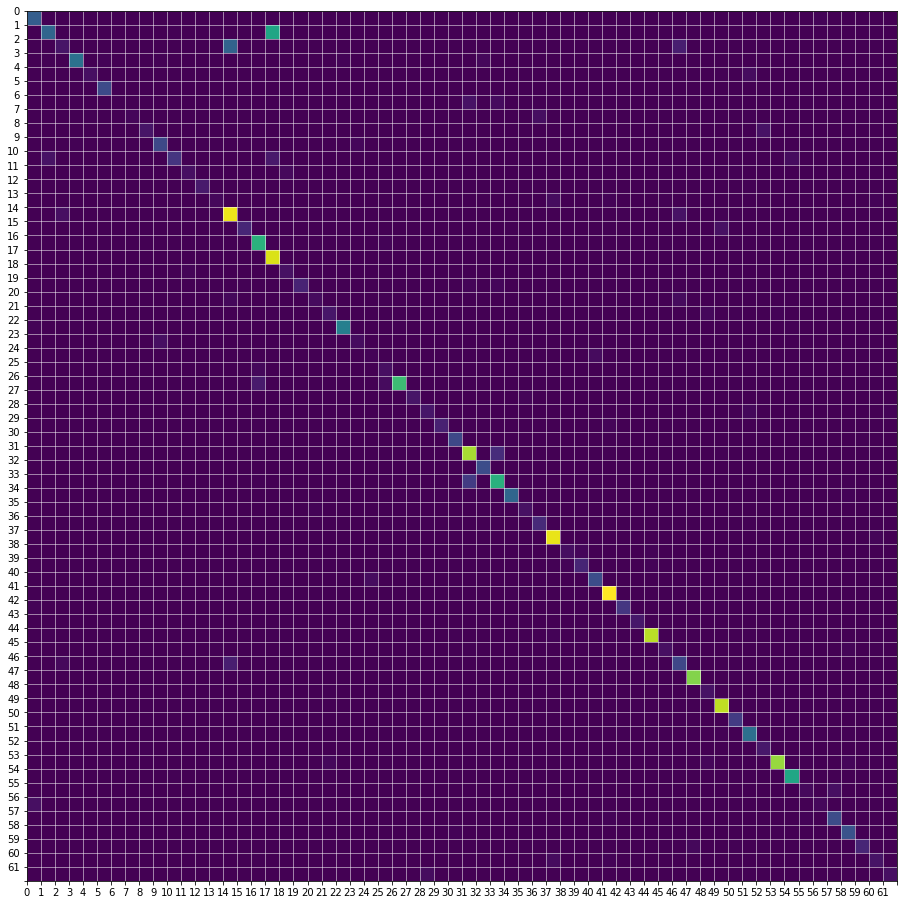

In [26]:
cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
fig = plt.figure(figsize=(16,16))
ax = plt.gca();
ax.set_xticks(np.arange(-.5, len(classes), 1))
ax.set_yticks(np.arange(-.5, len(classes), 1))
ax.set_xticklabels(np.arange(0, len(classes), 1))
ax.set_yticklabels(np.arange(0, len(classes), 1))
ax.imshow(cm)#, cmap="Pastel1")
ax.grid(which='major', color='w', linestyle='-', linewidth=0.5)

# Training Plots

Opening saved results...


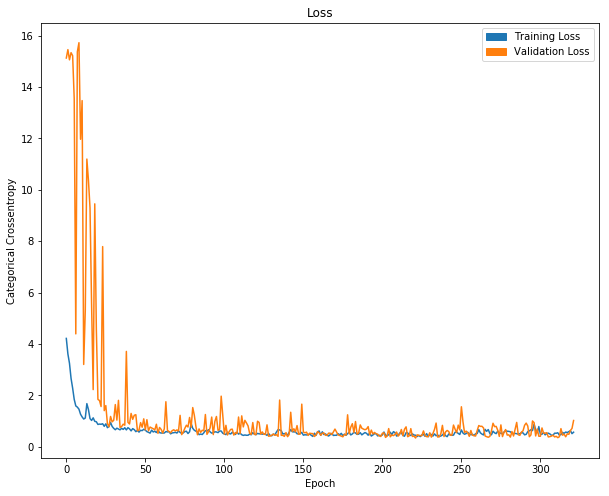

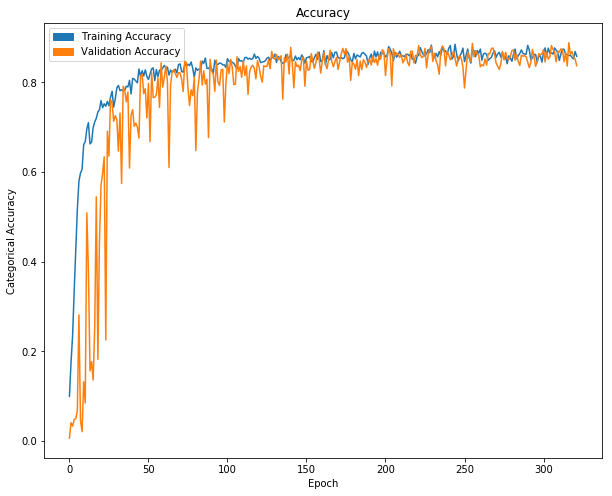

In [24]:
# saved "hist" results
# df = pd.DataFrame(hist.history)
# df.plot(figsize=(10,8))

# saved results
print("Opening saved results...")

df = pd.read_csv('sessions/' + train_name + '/log.csv')

plt.figure(figsize=(10,8))
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Categorical Crossentropy")

plt.legend(handles=[
    mpatches.Patch(color='C0', label='Training Loss'),
    mpatches.Patch(color='C1', label='Validation Loss')
])

plt.plot(df.epoch, df.loss)
plt.plot(df.epoch, df.val_loss)
plt.show()

plt.figure(figsize=(10,8))
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")

plt.legend(handles=[
    mpatches.Patch(color='C0', label='Training Accuracy'),
    mpatches.Patch(color='C1', label='Validation Accuracy')
])

plt.plot(df.epoch, df.categorical_accuracy)
plt.plot(df.epoch, df.val_categorical_accuracy)
plt.show()